**Реализация кастомного Trainer для дообучения модели с применением метода IRM**

Модель затратна по видеопамяти, поэтому используется небольшой batch_size < 10

*Если кто-то увидит причину буду благодарен за подсказку*

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Загрузка данных...
Полный словарь меток (13): {'O': 0, 'B-ADDRESS': 1, 'I-ADDRESS': 2, 'B-EMAIL': 3, 'I-EMAIL': 4, 'B-IP_ADDRESS': 5, 'I-IP_ADDRESS': 6, 'B-PERSON': 7, 'I-PERSON': 8, 'B-PHONE': 9, 'I-PHONE': 10, 'B-URL': 11, 'I-URL': 12}


2025-07-24 11:40:14.631482: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 11:40:15.813036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753357217.679524    8153 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753357218.190509    8153 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753357222.199422    8153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753357222.199456    8153 computation_placer.cc:177] computation placer already registered. Please che

Создание датасетов...
Используется устройство: cuda
Начало обучения...
Очистка CUDA кэша перед началом обучения...
Найдено сред: 4. Шагов в эпохе: 51

==================== Эпоха 1/5 ====================
  Эпоха 1, Шаг 50/51: Loss=0.4027, Acc=0.9277, Penalty=0.0257
Конец эпохи 1: Avg Loss: 1.1015, Avg Acc: 0.7422
Тестовые метрики: Loss=0.3174, Acc=0.9371, F1=0.9148

============================== СЛУЧАЙНЫЙ ТЕСТОВЫЙ ПРИМЕР ==============================
Токен                     | Истинная метка       | Предсказание        
----------------------------------------------------------------------
[CLS]                     | O                    | O                   
▁                         | O                    | O                   
timestamp                 | O                    | O                   
,                         | O                    | O                   
client                    | O                    | O                   
_                         | O            

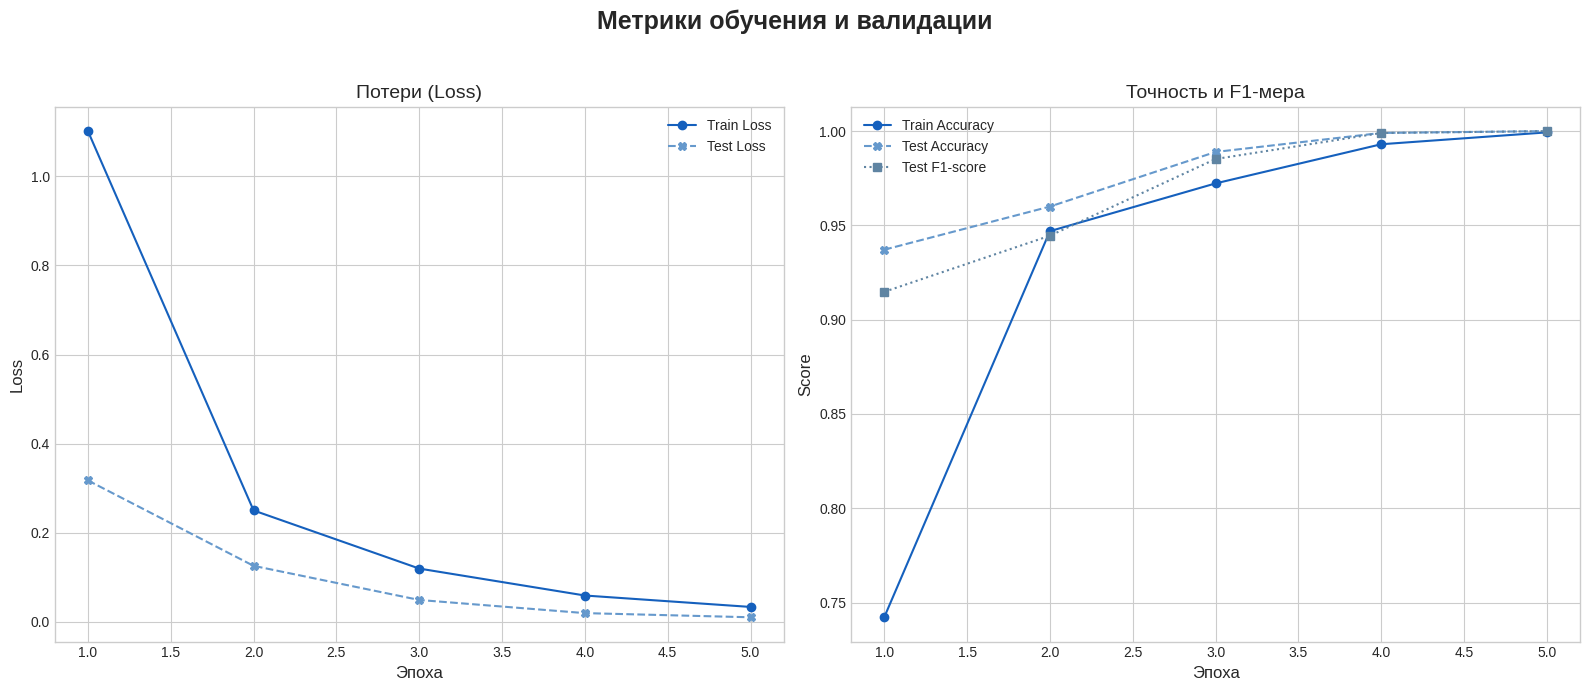

Графики сохранены в training_plots.pdf
Сохранение модели...
Обучение завершено!


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.nn import CrossEntropyLoss
from torch.autograd import grad
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import os
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import gc

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

COLORS = {
    'blue_grey': '#6699CC',
    'dusky_blue': '#5F84A2',
    'denim': '#1560BD',
    'light_grey': '#D3D3D3',
    'dark_grey': '#5A5A5A'
}

class PersonalDataDataset(Dataset):
    """
    Датасет для задачи классификации персональных данных.
    Принимает данные в формате CSV и преобразует их в формат, 
    пригодный для обучения модели.
    """
    def __init__(self, dataframe, tokenizer, label_to_id, max_length=512):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id
        self.id_to_label = {v: k for k, v in label_to_id.items()}
        self.max_length = max_length
        # Группируем данные по формату (это будут наши "среды" для IRM)
        self.environments = defaultdict(list)
        for idx, row in self.df.iterrows():
            self.environments[row['format_type']].append(idx)
        self.env_list = list(self.environments.keys())

    def __len__(self):
        return len(self.df)
    
    @staticmethod
    def collate_fn(batch):
        """
        Функция для объединения образцов в батч.
        Сделана статичной, чтобы ее можно было передавать в DataLoader напрямую.
        """
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        
        # Также передаем метаданные для отладки
        original_tokens = [item['original_tokens'] for item in batch]
        original_labels = [item['original_labels'] for item in batch]
        environments = [item['environment'] for item in batch]
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'original_tokens': original_tokens,
            'original_labels': original_labels,
            'environments': environments
        }

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tokens = row['mbert_tokens'].split()
        label_strings = row['mbert_token_classes'].split()

        #Усечение (Truncation) токенов и меток до max_length
        truncated_tokens = tokens[:self.max_length]
        truncated_label_strings = label_strings[:self.max_length]

        #Преобразование строковых токенов и меток в числовые ID
        input_ids = self.tokenizer.convert_tokens_to_ids(truncated_tokens)
        labels = [self.label_to_id.get(label, self.label_to_id['O']) for label in truncated_label_strings]
        
        attention_mask = [1] * len(input_ids)

        # 4. Дополнение (Padding) до max_length
        padding_length = self.max_length - len(input_ids)
        
        input_ids = input_ids + ([self.tokenizer.pad_token_id] * padding_length)
        labels = labels + ([-100] * padding_length) # -100 игнорируется функцией потерь
        attention_mask = attention_mask + ([0] * padding_length)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
            'environment': row['format_type'],
            'original_tokens': truncated_tokens, # Возвращаем усеченные токены для отладки
            'original_labels': truncated_label_strings
        }


class IRMTrainer:
    def __init__(self, model, tokenizer, num_labels, device='cpu', learning_rate=1e-5, label_to_id=None):
        self.model = model
        self.tokenizer = tokenizer
        self.num_labels = num_labels
        self.device = device
        self.learning_rate = learning_rate
        self.label_to_id = label_to_id
        self.id_to_label = {v: k for k, v in label_to_id.items()} if label_to_id else None
        
        self.dummy_classifier = torch.nn.Parameter(torch.ones(1, num_labels), requires_grad=True).to(device)
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        
        self.loss_func = CrossEntropyLoss(ignore_index=-100)
        self.log_history = []
        self.test_metrics_history = []

    def compute_penalty(self, logits, labels):
        scaled_logits = logits * self.dummy_classifier
        loss_for_penalty = self.loss_func(
            scaled_logits.view(-1, self.num_labels), 
            labels.view(-1)
        )
        try:
            grad_penalty = grad(loss_for_penalty, self.dummy_classifier, create_graph=True)[0]
            penalty = (grad_penalty ** 2).sum()
        except RuntimeError:
            penalty = torch.tensor(0.0, device=self.device)
        return penalty

    def calculate_accuracy(self, logits, labels):
        predictions = torch.argmax(logits, dim=-1)
        mask = labels != -100
        if mask.sum() == 0:
            return 0.0
        correct = (predictions[mask] == labels[mask]).sum().item()
        total = mask.sum().item()
        return correct / total if total > 0 else 0.0

    def train_step(self, environment_batches, reg_weight=1.0):
        self.optimizer.zero_grad()
        
        total_combined_loss = torch.tensor(0.0, device=self.device)
        total_main_loss = 0.0
        total_accuracy = 0.0
        total_penalty = 0.0
        num_environments = len(environment_batches)

        for batch in environment_batches:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            error = outputs.loss
            logits = outputs.logits
            penalty = self.compute_penalty(logits, labels)
            
            total_combined_loss = total_combined_loss + (error + reg_weight * penalty)
            
            total_main_loss += error.item()
            total_penalty += penalty.item()
            total_accuracy += self.calculate_accuracy(logits, labels)
            
        if num_environments > 0:
            avg_combined_loss = total_combined_loss / num_environments
            avg_combined_loss.backward()
            self.optimizer.step()
            
            avg_main_loss = total_main_loss / num_environments
            avg_accuracy = total_accuracy / num_environments
            avg_penalty = total_penalty / num_environments
        else:
            avg_main_loss = avg_accuracy = avg_penalty = 0.0

        return {
            'loss': avg_main_loss,
            'accuracy': avg_accuracy,
            'penalty': avg_penalty
        }
    
    def train(self, dataset, test_dataset=None, epochs=3, batch_size=8, reg_weight=1.0):
        if torch.cuda.is_available():
            print("Очистка CUDA кэша перед началом обучения...")
            torch.cuda.empty_cache()
            gc.collect()

        env_loaders = {}
        for env_name, indices in dataset.environments.items():
            if len(indices) > 0:
                env_subset = torch.utils.data.Subset(dataset, indices)
                env_loaders[env_name] = DataLoader(
                    env_subset, 
                    batch_size=batch_size, 
                    shuffle=True,
                    collate_fn=PersonalDataDataset.collate_fn,
                    num_workers=2,
                    pin_memory=True
                )
        
        if not env_loaders:
            print("Нет данных для обучения.")
            return
            
        steps_per_epoch = max(len(loader) for loader in env_loaders.values())
        print(f"Найдено сред: {len(env_loaders)}. Шагов в эпохе: {steps_per_epoch}")

        self.model.train()
        
        for epoch in range(epochs):
            print(f"\n{'='*20} Эпоха {epoch + 1}/{epochs} {'='*20}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
            
            env_iterators = {name: iter(loader) for name, loader in env_loaders.items()}
            
            epoch_losses, epoch_accuracies, epoch_penalties = [], [], []

            for step in range(steps_per_epoch):
                environment_batches = []
                for name, iterator in env_iterators.items():
                    try:
                        batch = next(iterator)
                        environment_batches.append(batch)
                    except StopIteration:
                        env_iterators[name] = iter(env_loaders[name])
                        batch = next(env_iterators[name])
                        environment_batches.append(batch)

                result = self.train_step(environment_batches, reg_weight)
                epoch_losses.append(result['loss'])
                epoch_accuracies.append(result['accuracy'])
                epoch_penalties.append(result['penalty'])
                
                if (step + 1) % 50 == 0:
                    print(f"  Эпоха {epoch+1}, Шаг {step+1}/{steps_per_epoch}: "
                          f"Loss={result['loss']:.4f}, "
                          f"Acc={result['accuracy']:.4f}, "
                          f"Penalty={result['penalty']:.4f}")

            avg_loss = np.mean(epoch_losses)
            avg_accuracy = np.mean(epoch_accuracies)
            avg_penalty = np.mean(epoch_penalties)
            
            self.log_history.append({
                'epoch': epoch + 1, 'loss': avg_loss,
                'accuracy': avg_accuracy, 'penalty': avg_penalty
            })
            print(f"Конец эпохи {epoch + 1}: Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_accuracy:.4f}")

            if test_dataset:
                test_metrics = self.evaluate_model(test_dataset, batch_size)
                self.test_metrics_history.append(test_metrics)
                print(f"Тестовые метрики: Loss={test_metrics['loss']:.4f}, Acc={test_metrics['accuracy']:.4f}, F1={test_metrics['f1']:.4f}")
                self.print_random_test_sample(test_dataset)

        if self.test_metrics_history:
            self.plot_metrics()

    def evaluate_model(self, dataset, batch_size=16):
        self.model.eval()
        all_predictions, all_labels = [], []
        total_loss, num_batches = 0.0, 0
        
        test_loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False,
            collate_fn=PersonalDataDataset.collate_fn
        )
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                
                total_loss += outputs.loss.item()
                num_batches += 1
                
                predictions = torch.argmax(outputs.logits, dim=-1)
                mask = labels != -100
                all_predictions.extend(predictions[mask].cpu().numpy())
                all_labels.extend(labels[mask].cpu().numpy())
        
        self.model.train()
        
        unique_labels = list(set(all_labels))
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, labels=unique_labels, average='weighted', zero_division=0
        )
        return {
            'loss': total_loss / num_batches if num_batches > 0 else 0.0,
            'accuracy': accuracy_score(all_labels, all_predictions),
            'precision': precision, 'recall': recall, 'f1': f1
        }
        
    def print_random_test_sample(self, test_dataset):
        if not test_dataset or not self.id_to_label:
            print("Тестовый датасет недоступен или отсутствует отображение меток")
            return
            
        sample_idx = random.randint(0, len(test_dataset) - 1)
        sample = test_dataset[sample_idx]
        
        input_ids = sample['input_ids'].unsqueeze(0).to(self.device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(self.device)
        true_labels_padded = sample['labels']
        original_tokens = sample['original_tokens']
        
        self.model.eval()
        with torch.no_grad():
            logits = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
            predictions_padded = torch.argmax(logits, dim=-1).squeeze(0)
        self.model.train()
        
        print(f"\n{'='*30} СЛУЧАЙНЫЙ ТЕСТОВЫЙ ПРИМЕР {'='*30}")
        print(f"{'Токен':<25} | {'Истинная метка':<20} | {'Предсказание':<20}")
        print("-" * 70)
        
        for i, token in enumerate(original_tokens):
            true_label_id = true_labels_padded[i].item()
            pred_label_id = predictions_padded[i].item()

            true_label_str = self.id_to_label.get(true_label_id, "N/A")
            pred_label_str = self.id_to_label.get(pred_label_id, "N/A")

            marker = " ❌" if true_label_str != pred_label_str else ""
            print(f"{token:<25} | {true_label_str:<20} | {pred_label_str:<20}{marker}")
            
        print(f"{'='*80}\n")
    
    def plot_metrics(self, save_path='training_plots.pdf'):
        if not self.log_history or not self.test_metrics_history:
            print("Недостаточно данных для построения графиков")
            return
            
        epochs = [entry['epoch'] for entry in self.log_history]
        train_losses = [entry['loss'] for entry in self.log_history]
        train_accuracies = [entry['accuracy'] for entry in self.log_history]
        test_losses = [entry['loss'] for entry in self.test_metrics_history]
        test_accuracies = [entry['accuracy'] for entry in self.test_metrics_history]
        test_f1s = [entry['f1'] for entry in self.test_metrics_history]
        
        plt.style.use('seaborn-v0_8-whitegrid') # Используем приятный стиль
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        fig.suptitle('Метрики обучения и валидации', fontsize=18, weight='bold')
        
        # График потерь (Loss)
        ax1.plot(epochs, train_losses, color=COLORS['denim'], marker='o', linestyle='-', label='Train Loss')
        ax1.plot(epochs, test_losses, color=COLORS['blue_grey'], marker='X', linestyle='--', label='Test Loss')
        ax1.set_title('Потери (Loss)', fontsize=14)
        ax1.set_xlabel('Эпоха', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.legend()
        
        # График точности и F1
        ax2.plot(epochs, train_accuracies, color=COLORS['denim'], marker='o', linestyle='-', label='Train Accuracy')
        ax2.plot(epochs, test_accuracies, color=COLORS['blue_grey'], marker='X', linestyle='--', label='Test Accuracy')
        ax2.plot(epochs, test_f1s, color=COLORS['dusky_blue'], marker='s', linestyle=':', label='Test F1-score')
        ax2.set_title('Точность и F1-мера', fontsize=14)
        ax2.set_xlabel('Эпоха', fontsize=12)
        ax2.set_ylabel('Score', fontsize=12)
        ax2.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        with PdfPages(save_path) as pdf:
            pdf.savefig(fig)
        
        plt.show()
        print(f"Графики сохранены в {save_path}")

def get_base_labels(label_strings):
    base_labels = set()
    for label in label_strings:
        if label.startswith('B-') or label.startswith('I-'):
            base_labels.add(label[2:])
        else:
            base_labels.add(label)
    return base_labels

def main():
    print("Загрузка данных...")
    try:
        df = pd.read_csv('generated_pii_dataset_structured.csv')
    except FileNotFoundError:
        print("Ошибка: Файл 'generated_logs_dataset_by_format_large.csv' не найден.")
        print("Пожалуйста, убедитесь, что файл находится в той же директории, что и скрипт, или укажите полный путь.")
        return

    all_base_labels = set()
    train_df = df[df['split'] == 'train'].copy() # Используем .copy() для избежания SettingWithCopyWarning
    for labels_str in train_df['mbert_token_classes']:
        if isinstance(labels_str, str):
            all_base_labels.update(get_base_labels(labels_str.split()))

    unique_base_labels = sorted([l for l in all_base_labels if l != 'O'])
    full_label_to_id = {'O': 0}
    current_id = 1
    for base_label in unique_base_labels:
        full_label_to_id[f'B-{base_label}'] = current_id
        current_id += 1
        full_label_to_id[f'I-{base_label}'] = current_id
        current_id += 1
    
    print(f"Полный словарь меток ({len(full_label_to_id)}): {full_label_to_id}")

    model_name = "iiiorg/piiranha-v1-detect-personal-information"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(full_label_to_id),
        id2label={v: k for k, v in full_label_to_id.items()},
        label2id=full_label_to_id,
        ignore_mismatched_sizes=True
    )
    
    print("Создание датасетов...")
    train_dataset = PersonalDataDataset(train_df, tokenizer, full_label_to_id)
    test_df = df[df['split'] == 'test'].copy()
    test_dataset = PersonalDataDataset(test_df, tokenizer, full_label_to_id) if len(test_df) > 0 else None

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Используется устройство: {device}")

    trainer = IRMTrainer(model, tokenizer, len(full_label_to_id), device=device, label_to_id=full_label_to_id)
    
    print("Начало обучения...")
    trainer.train(train_dataset, test_dataset=test_dataset, epochs=5, batch_size=16, reg_weight=1.0)
    
    print("Сохранение модели...")
    save_dir = './trained_model_irm'
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    with open(os.path.join(save_dir, 'label_to_id.json'), 'w', encoding='utf-8') as f:
        json.dump(full_label_to_id, f, ensure_ascii=False, indent=4)

    print("Обучение завершено!")

if __name__ == "__main__":
    main()